# Red Neuronal Recurrente: datos secuenciales/temporales

Se realizará una predicción del precio del bitcoin utilizando los precios de Ethereum, Cardano, Binance Coin, TetherUSD, SP 500, Nasqad, Dow Jones y el Oro. Los set de datos a utilizar se obtendrán de:

<table>
	<thead>
		<tr>
			<td>Aset</td>
			<td>ULR</td>
		</tr>
	</thead>
	<tbody>
		<tr>
			<td>BTC</td>
			<td>https://finance.yahoo.com/quote/BTC-USD/history/</td>
		</tr>
		<tr>
			<td>ETH</td>
			<td>https://finance.yahoo.com/quote/ETH-USD/history/</td>
		</tr>
		<tr>
			<td>ADA</td>
			<td>https://finance.yahoo.com/quote/ADA-USD/history/</td>
		</tr>
		<tr>
			<td>BNB</td>
			<td>https://finance.yahoo.com/quote/BNB-USD/history/</td>
		</tr>
		<tr>
			<td>USDT</td>
			<td>https://finance.yahoo.com/quote/USDT-USD/history/</td>
		</tr>
		<tr>
			<td>Down Jones</td>
			<td>https://finance.yahoo.com/quote/%5EDJI/history</td>
		</tr>
		<tr>
			<td>S&P 500</td>
			<td>https://finance.yahoo.com/quote/%5EGSPC/history</td>
		</tr>
		<tr>
			<td>NASDAQ</td>
			<td>https://finance.yahoo.com/quote/%5EIXIC/history</td>
		</tr>
		<tr>
			<td>Oro</td>
			<td>https://es.finance.yahoo.com/quote/GC%3DF/history</td>
		</tr>
	</tbody>
</table>

# Librerías a utilizar en el proyecto

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.parser import parse
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
plt.rcParams["figure.figsize"] = (16, 12)

Evita imprimir varios logs al momento de entrenar el modelo con Keras

In [2]:
from tqdm.keras import TqdmCallback

# Cargando datos

In [3]:
ada = pd.read_csv('data3/ADA-USD.csv', delimiter=',')
ada["Date"] = pd.to_datetime(ada["Date"])
ada = ada.sort_values('Date', ascending=True)

bnb = pd.read_csv('data3/BNB-USD.csv', delimiter=',')
bnb["Date"] = pd.to_datetime(bnb["Date"])
bnb = bnb.sort_values('Date', ascending=True)

btc = pd.read_csv('data3/BTC-USD.csv', delimiter=',')
btc["Date"] = pd.to_datetime(btc["Date"])
btc = btc.sort_values('Date', ascending=True)

eth = pd.read_csv('data3/ETH-USD.csv', delimiter=',')
eth["Date"] = pd.to_datetime(eth["Date"])
eth = eth.sort_values('Date', ascending=True)

djones = pd.read_csv('data3/DOW-JONES.csv', delimiter=',')
djones["Date"] = pd.to_datetime(djones["Date"])
djones = djones.sort_values('Date', ascending=True)

nasdaq = pd.read_csv('data3/nasdaq.csv', delimiter=',')
nasdaq["Date"] = pd.to_datetime(nasdaq["Date"])
nasdaq = nasdaq.sort_values('Date', ascending=True)

oro = pd.read_csv('data3/oro.csv', delimiter=',')
oro["Date"] = pd.to_datetime(oro["Date"])
oro = oro.sort_values('Date', ascending=True)

sp500 = pd.read_csv('data3/sp500.csv', delimiter=',')
sp500["Date"] = pd.to_datetime(sp500["Date"])
sp500 = sp500.sort_values('Date', ascending=True)

usdt = pd.read_csv('data3/USDT-USD.csv', delimiter=',')
usdt["Date"] = pd.to_datetime(usdt["Date"])
usdt = usdt.sort_values('Date', ascending=True)

Columnas:

In [4]:
columnas = ada.columns
columnas

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

Graficando percio de cierre diario

Text(0.5, 0.98, 'Precio de cierre diario')

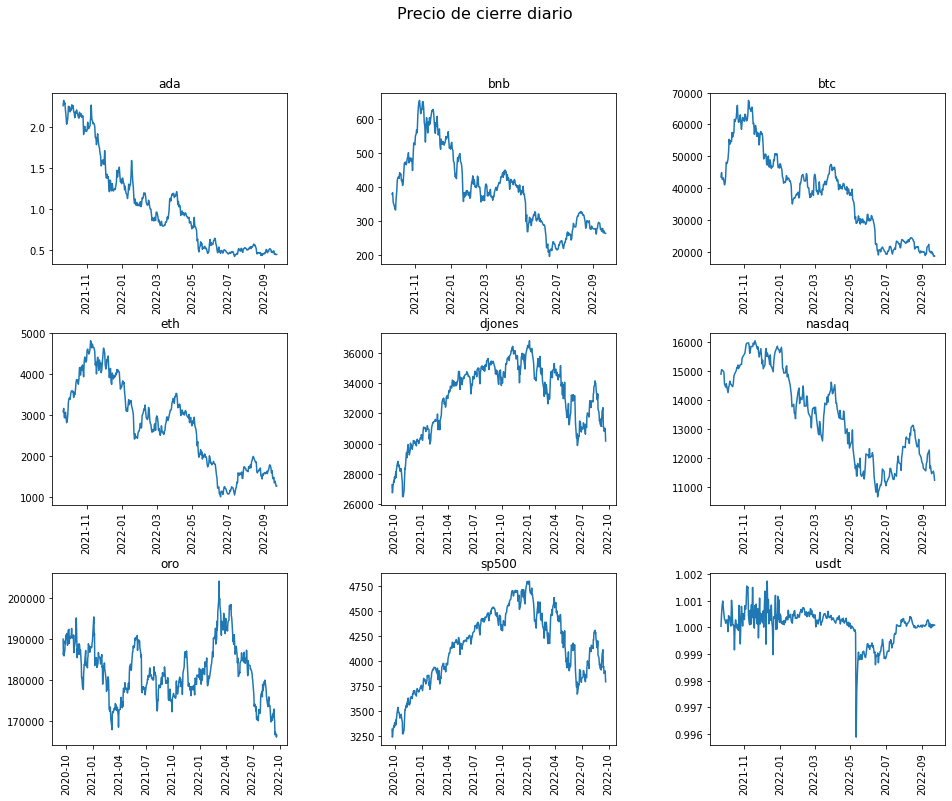

In [5]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

data = ([ada, "ada"], [bnb, "bnb"], [btc, "btc"], [eth, "eth"], [djones, "djones"], [nasdaq, "nasdaq"], [oro, "oro"], [sp500, "sp500"], [usdt, "usdt"])

for i in range(1, len(data)+1):
    d = data[i-1]
    ax = fig.add_subplot(3, 3, i)
    ax.plot(d[0]['Date'], d[0]['Close'])
    ax.set_title(d[1])
    plt.xticks(rotation='vertical')
    
fig.suptitle('Precio de cierre diario', fontsize=16)

Graficando volumen

Text(0.5, 0.98, 'Volumen')

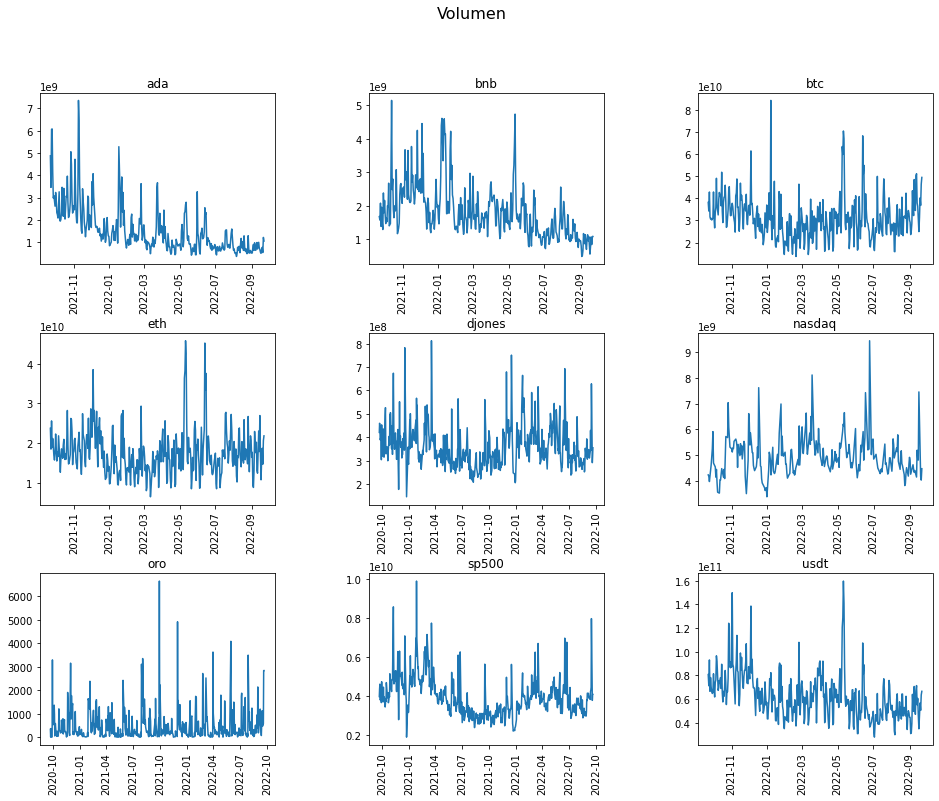

In [6]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1, len(data)+1):
    d = data[i-1]
    ax = fig.add_subplot(3, 3, i)
    ax.plot(d[0]['Date'], d[0]['Volume'])
    ax.set_title(d[1])
    plt.xticks(rotation='vertical')
    
fig.suptitle('Volumen', fontsize=16)

# Tratamiento de datos

Normalización:

In [7]:
#Minimos y maxmos
ada_min, ada_max = ada.iloc[:,1:].min(axis=0), ada.iloc[:,1:].max(axis=0)
bnb_min, bnb_max = bnb.iloc[:,1:].min(axis=0), bnb.iloc[:,1:].max(axis=0)
btc_min, btc_max = btc.iloc[:,1:].min(axis=0), btc.iloc[:,1:].max(axis=0)
eth_min, eth_max = eth.iloc[:,1:].min(axis=0), eth.iloc[:,1:].max(axis=0)
djones_min, djones_max = djones.iloc[:,1:].min(axis=0), djones.iloc[:,1:].max(axis=0)
nasdaq_min, nasdaq_max = nasdaq.iloc[:,1:].min(axis=0), nasdaq.iloc[:,1:].max(axis=0)
oro_min, oro_max = oro.iloc[:,1:].min(axis=0), oro.iloc[:,1:].max(axis=0)
sp500_min, sp500_max = sp500.iloc[:,1:].min(axis=0), sp500.iloc[:,1:].max(axis=0)
usdt_min, usdt_max = usdt.iloc[:,1:].min(axis=0), usdt.iloc[:,1:].max(axis=0)

#Escalando
ada_escala = (ada.iloc[:,1:] - ada_min) / (ada_max - ada_min)
bnb_escala = (bnb.iloc[:,1:] - bnb_min) / (bnb_max - bnb_min)
btc_escala = (btc.iloc[:,1:] - btc_min) / (btc_max - btc_min)
eth_escala = (eth.iloc[:,1:] - eth_min) / (eth_max - eth_min)
djones_escala = (djones.iloc[:,1:] - djones_min) / (djones_max - djones_min)
nasdaq_escala = (nasdaq.iloc[:,1:] - nasdaq_min) / (nasdaq_max - nasdaq_min)
oro_escala = (oro.iloc[:,1:] - oro_min) / (oro_max - oro_min)
sp500_escala = (sp500.iloc[:,1:] - sp500_min) / (sp500_max - sp500_min)
usdt_escala = (usdt.iloc[:,1:] - usdt_min) / (usdt_max - usdt_min)

ada_escala["Date"] = ada["Date"]
bnb_escala["Date"] = bnb["Date"]
btc_escala["Date"] = btc["Date"]
eth_escala["Date"] = eth["Date"]
djones_escala["Date"] = djones["Date"]
nasdaq_escala["Date"] = nasdaq["Date"]
oro_escala["Date"] = oro["Date"]
sp500_escala["Date"] = sp500["Date"]
usdt_escala["Date"] = usdt["Date"]

Graficando datos normalizados, es posible ver que están en el rango 0, 1

Text(0.5, 0.98, 'Precio de cierre diario')

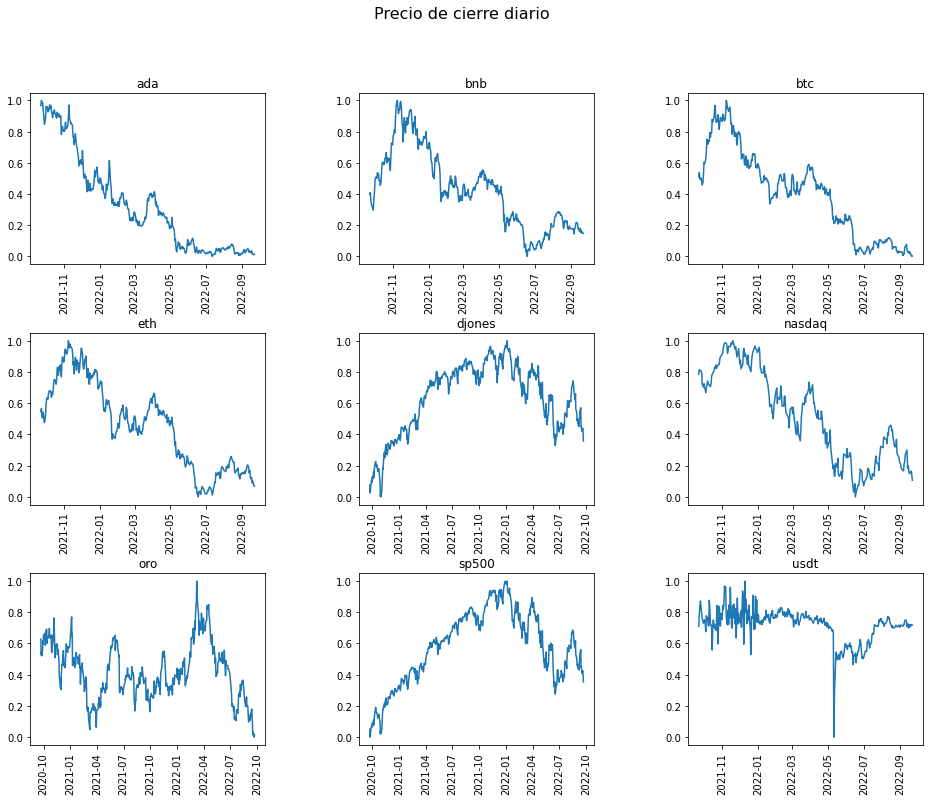

In [8]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

data_escala = ([ada_escala, "ada"], [bnb_escala, "bnb"], [btc_escala, "btc"], [eth_escala, "eth"], [djones_escala, "djones"], [nasdaq_escala, "nasdaq"], [oro_escala, "oro"], [sp500_escala, "sp500"], [usdt_escala, "usdt"])

for i in range(1, len(data_escala)+1):
    d = data_escala[i-1]
    d2 = data[i-1]
    ax = fig.add_subplot(3, 3, i)
    ax.plot(d2[0]['Date'], d[0]["Close"])
    ax.set_title(d[1])
    plt.xticks(rotation='vertical')
    
fig.suptitle('Precio de cierre diario', fontsize=16)

Graficando volumen

Text(0.5, 0.98, 'Volumen diario')

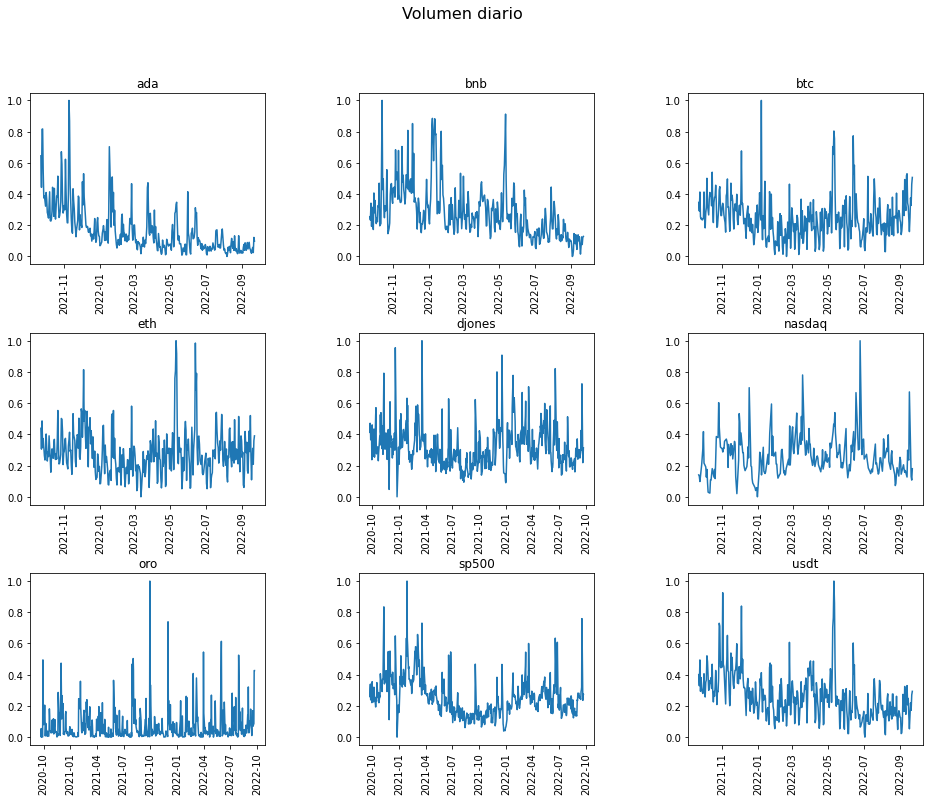

In [9]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1, len(data_escala)+1):
    d = data_escala[i-1]
    d2 = data[i-1]
    ax = fig.add_subplot(3, 3, i)
    ax.plot(d2[0]['Date'], d[0]["Volume"])
    ax.set_title(d[1])
    plt.xticks(rotation='vertical')
    
fig.suptitle('Volumen diario', fontsize=16)

Obteniendo únicamente fechas que están en los 9 set de datos

In [10]:
dates = pd.DataFrame()
for i in range(0, len(data)):
    d = data[i]
    dates = pd.concat([dates, d[0]["Date"]], axis=0)
repitencia = dates.groupby(dates.columns.tolist(),as_index=False).size()
repetidos = repitencia[0][repitencia["size"]==9]
repetidos = pd.to_datetime(repetidos)
repetidos = pd.DataFrame({"Date": repetidos})
repetidos.head()

,Date
252,2021-09-22
253,2021-09-23
254,2021-09-24
257,2021-09-27
258,2021-09-28


Filtrando registros

In [11]:
ada_unique = ada_escala.loc[ada["Date"].isin(repetidos["Date"]),:].copy()
bnb_unique = bnb_escala.loc[bnb["Date"].isin(repetidos["Date"]),:].copy()
btc_unique = btc_escala.loc[btc["Date"].isin(repetidos["Date"]),:].copy()
eth_unique = eth_escala.loc[eth["Date"].isin(repetidos["Date"]),:].copy()
djones_unique = djones_escala.loc[djones["Date"].isin(repetidos["Date"]),:].copy()
nasdaq_unique = nasdaq_escala.loc[nasdaq["Date"].isin(repetidos["Date"]),:].copy()
oro_unique = oro_escala.loc[oro["Date"].isin(repetidos["Date"]),:].copy()
sp500_unique = sp500_escala.loc[sp500["Date"].isin(repetidos["Date"]),:].copy()
usdt_unique = usdt_escala.loc[usdt["Date"].isin(repetidos["Date"]),:].copy()

Preparando set de datos final. Los valores Y tendrán  una semana adelantada, esto servirá para que el modelo pueda predecir resultados maximo en una semana.

In [12]:
close_index = np.argmax(columnas == "Close")-1
volume_index = np.argmax(columnas == "Volume")-1

dfX = pd.DataFrame({
    "ada_close": np.array(ada_unique.iloc[:, close_index]),
    "bnb_close": np.array(bnb_unique.iloc[:, close_index]),
    "eth_close": np.array(eth_unique.iloc[:, close_index]),
    "djones_close": np.array(djones_unique.iloc[:, close_index]),
    "nasdaq_close": np.array(nasdaq_unique.iloc[:, close_index]),
    "oro_close": np.array(oro_unique.iloc[:, close_index]),
    "sp500_close": np.array(sp500_unique.iloc[:, close_index]),
    "usdt_close": np.array(usdt_unique.iloc[:, close_index]),
    
    "ada_volume": np.array(ada_unique.iloc[:, volume_index]),
    "bnb_volume": np.array(bnb_unique.iloc[:, volume_index]),
    "eth_volume": np.array(eth_unique.iloc[:, volume_index]),
    "djones_volume": np.array(djones_unique.iloc[:, volume_index]),
    "nasdaq_volume": np.array(nasdaq_unique.iloc[:, volume_index]),
    "oro_volume": np.array(oro_unique.iloc[:, volume_index]),
    "sp500_volume": np.array(sp500_unique.iloc[:, volume_index]),
    "usdt_volume": np.array(usdt_unique.iloc[:, volume_index])
})

#X
#Predicción para los siguientes siete días
w=len(dfX)-3
dfX_next_week = dfX.loc[w:,:]

#Datos para entrenamiento y pruebas
dfX = dfX.loc[:w-1,:].reset_index(drop=True)
dfX = dfX.reset_index(drop=True)

#Y
dfY = pd.DataFrame({
    "btc_close": np.array(btc_unique.iloc[:, close_index])
})

#Predicción de una semana
dfY = dfY.loc[3:,:].reset_index(drop=True)

dfX.head()

,ada_close,bnb_close,eth_close,djones_close,nasdaq_close,oro_close,sp500_close,usdt_close,ada_volume,bnb_volume,eth_volume,djones_volume,nasdaq_volume,oro_volume,sp500_volume,usdt_volume
0,0.966148,0.398881,0.545832,0.753222,0.785526,0.307571,0.742941,0.710293,0.644985,0.255162,0.438891,0.226648,0.140291,0.002412,0.173726,0.400711
1,1.000000,0.408460,0.566169,0.802406,0.814242,0.231335,0.777141,0.790048,0.442713,0.233155,0.305615,0.207588,0.131486,0.004523,0.118630,0.328996
2,0.974035,0.346125,0.507544,0.805628,0.813403,0.236593,0.781309,0.843217,0.815003,0.341498,0.486157,0.163195,0.097754,0.011307,0.110973,0.494542
3,0.898048,0.304301,0.508191,0.812559,0.799039,0.237382,0.773377,0.790900,0.374942,0.218275,0.322135,0.215977,0.204590,0.121664,0.143599,0.320139
4,0.847465,0.297393,0.474973,0.757269,0.720816,0.200053,0.715364,0.754260,0.389655,0.172617,0.264269,0.350357,0.259850,0.002223,0.201538,0.291953


In [13]:
dfY.head()

,btc_close
0,0.483244
1,0.458739
2,0.469548
3,0.514969
4,0.603221


# Datos de entrenamiento y pruebas

Separación de datos para entrenamiento y validación

In [14]:
longitud = int(len(dfX)*0.98)
X_train_model = np.array(dfX)[:longitud,:]
X_validation = np.array(dfX)[longitud:,:]
dfY_array = np.array(dfY.reset_index(drop=True))
y_train_model = dfY_array[:longitud]
y_validation = dfY_array[longitud:]

Separación de datos para entrenamiento

In [15]:
longitud = int(len(X_train_model)*0.8)
X_train = X_train_model[:longitud,:]
X_test = X_train_model[longitud:,:]
y_train = y_train_model[:longitud]
y_test = y_train_model[longitud:]

Redimensioanmiento para entrenamiento recurrente

In [16]:
dfX_next_week = np.reshape(np.array(dfX_next_week), (dfX_next_week.shape[0], 1, dfX_next_week.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

Creación de batches para entrenamiento:

In [17]:
train_batches = TimeseriesGenerator(X_train, y_train, length=1, batch_size=18)
test_batches = TimeseriesGenerator(X_test, y_test, length=1, batch_size=18)

# Modelo Keras

## Custom callback

In [18]:
class custom_callback(Callback):
    
    def on_epoch_end(self, batch, logs):
        mse = logs.get('mse')
        
        if( mse < 0.000005 ):
            self.model.stop_training = True

## Modelo secuencial LSTM 

Long Short-Term Memory network

In [19]:
modelo = Sequential()
modelo.add(LSTM(128, input_shape=(1,16,), activation="relu", return_sequences=True, kernel_initializer=GlorotNormal()))
modelo.add(Dropout(0.1, input_shape=(128,)))
modelo.add(LSTM(128, activation="relu", return_sequences=True))
modelo.add(Dropout(0.1, input_shape=(128,)))
modelo.add(LSTM(128, activation="relu", return_sequences=True))
modelo.add(Dropout(0.1, input_shape=(128,)))
modelo.add(LSTM(128, activation="relu", return_sequences=True))
modelo.add(Dropout(0.1, input_shape=(128,)))

modelo.add(Dense(64, activation="relu"))
modelo.add(Dropout(0.1, input_shape=(64,)))
modelo.add(Dense(32, activation="relu"))
modelo.add(Dropout(0.1, input_shape=(32,)))
modelo.add(Dense(16, activation="relu"))
modelo.add(Dropout(0.1, input_shape=(16,)))
modelo.add(Dense(8, activation="relu"))
modelo.add(Dropout(0.1, input_shape=(8,)))
modelo.add(Dense(1, activation="relu"))

callbacks = custom_callback()

#Guardar modelo con el menor mse
modelo_checkpoint_callback = ModelCheckpoint(
    filepath='data3/modelo_final',
    save_weights_only=True,
    monitor='mse',
    mode='min',
    save_best_only=True)

modelo.compile(
    loss="mean_squared_error", 
    optimizer="adam", 
    metrics=[MeanSquaredError(name="mse")])

historial_prediccion = modelo.fit(
    train_batches,
    validation_data=test_batches, 
    epochs=800,
    verbose=0, 
    callbacks=[callbacks, TqdmCallback(verbose=1), modelo_checkpoint_callback])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Error en el entrenamiento:

In [20]:
print("Loss:", historial_prediccion.history["loss"][-1])

Loss: 0.003076966619119048


# Predicción

In [21]:
predicciones = modelo.predict(X_validation)

Error cuadratico medio de la predicción:

In [22]:
mse = mean_squared_error(predicciones.flatten(), y_validation.flatten())
print("MSE: %.4f" % mse)
print("Error: %.4f" % np.sqrt(mse))

MSE: 0.0118
Error: 0.1085


# Predicción para la siguiente semana

In [23]:
predicciones_nex_week = modelo.predict(dfX_next_week)
predicciones_nex_week = predicciones_nex_week.reshape(predicciones_nex_week.shape[0], 1)

Mostrando predicciones:

In [24]:
R = predicciones_nex_week*(np.array(btc_max[["Close"]].to_frame().T) - np.array(btc_min[["Close"]].to_frame().T)) + np.array(btc_min[["Close"]].to_frame().T)
dias = 1
for i in R:   
    print("En",dias,"dias")
    print("Cierre:", "{:,}".format(round(i[0],2)))  
    dias=dias+1
    print("")

En 1 dias
Cierre: 18,547.4

En 2 dias
Cierre: 23,205.16

En 3 dias
Cierre: 18,547.4

